In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
# from sklearn.preprocessing import MinMaxScaler

2023-09-11 15:26:18.326898: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 15:26:18.794213: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# gpus = tf.config.list_physical_devices(device_type = 'GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
num_epochs = 150
batch_size = 128
learning_rate = 0.001

In [4]:
class DataLoader:
    def __init__(self):
        AS_dataset = pd.read_csv('./Arbitrary_Single_band_Coupler_Phase_Shift.csv', encoding='utf-8')
        self.X = AS_dataset.loc[:,'freq':'L4'].to_numpy(dtype=np.float32)
        self.y = AS_dataset.loc[:,'S11r':'S41i'].to_numpy(dtype=np.float32)
#         self.mmX = MinMaxScaler()
#         self.X[:,1:] = self.mmX.fit_transform(self.X[:,1:])
        # self.X[:,0] = self.X[:,0] * 10
        self.X_train, self.X_vali, self.y_train, self.y_vali = train_test_split(self.X, self.y, test_size=0.1, random_state=0)
        self.num_train = self.X_train.shape[0]
    def get_batch(self, batch_size=0, mode='train'):
        if mode == 'train':
            index = np.random.randint(0, self.num_train, batch_size)
            return self.X_train[index], self.y_train[index]
        if mode == 'validate':
            return self.X_vali, self.y_vali

In [3]:
AS_dataset = pd.read_csv('./Arbitrary_Single_band_Coupler_Phase_Shift.csv', encoding='utf-8')
full_X = AS_dataset.loc[:,'freq':'L4'].to_numpy(dtype = np.float32)
full_y = AS_dataset.loc[:,'S11r':'S41i'].to_numpy(dtype = np.float32)
dataset_train = tf.data.Dataset.from_tensor_slices((full_X, full_y))
dataset_train = dataset_train.shuffle(buffer_size=23000)
dataset_train = dataset_train.batch(batch_size)
dataset_train = dataset_train.prefetch(tf.data.experimental.AUTOTUNE)

2023-09-11 15:26:24.713055: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9604 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-09-11 15:26:24.713585: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9621 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


In [4]:
class MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(units=128, activation=tf.nn.leaky_relu)
        self.dense2 = tf.keras.layers.Dense(units=1024, activation=tf.nn.leaky_relu)
        self.dense3 = tf.keras.layers.Dense(units=512, activation=tf.nn.leaky_relu)
        self.dense4 = tf.keras.layers.Dense(units=128, activation=tf.nn.leaky_relu)
        self.dense5 = tf.keras.layers.Dense(units=8)
    
#     @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        output = self.dense5(x)
        return output

In [5]:
model = MLP()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

GT_struct = tf.constant([2.27248, 2.52657, 1.06926, 3.83355, 1.92307, 1.74249, 1.37051,  1.52846,  17.2486, 66.9054, 18.5276, 50.3882])
# GT_struct = tf.constant([2.28537, 3.26143, 1.77117, 3.44183, 1.36415, 1.79982, 3.4657, 1.00883, 17.4404, 67.2932, 14.5402, 47.8842])
GT_X = tf.concat([tf.constant([[2.4], [2.5], [2.6]]), tf.repeat([GT_struct], 3, axis=0)], axis=1)
GT_S = tf.constant([[0.016, 0.075, 0.743, 0.343, 0.496, -0.185, -0.147, 0.005],
[-0.021, 0.003, 0.827, 0.089, 0.414, -0.333, -0.026, -0.018],
[-0.093, -0.046, 0.802, -0.177, 0.281, -0.444, 0.052, -0.109]])

2023-09-08 21:21:39.518294: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55e34aa4a4d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-08 21:21:39.518315: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-09-08 21:21:39.518319: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-09-08 21:21:39.521525: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-08 21:21:39.624543: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-08 21:21:39.731394: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


epoch:0
train mse:0.10091333091259003 rmse:0.3176685869693756 mae:0.2613268494606018 r2:0.15918058156967163 EC:0.45485931634902954
GT mse:0.1251460164785385 rmse:0.3537598252296448 mae:0.2794783115386963 r2:-0.12968111038208008
epoch:10
train mse:0.025261923670768738 rmse:0.15894000232219696 mae:0.12514552474021912 r2:0.7872209548950195 EC:0.7571230530738831
GT mse:0.07880794256925583 rmse:0.2807275354862213 mae:0.2345132976770401 r2:0.288608193397522
epoch:20
train mse:0.023359766229987144 rmse:0.15283901989459991 mae:0.11025897413492203 r2:0.8073961734771729 EC:0.7662386298179626
GT mse:0.05261813476681709 rmse:0.22938643395900726 mae:0.18351805210113525 r2:0.5250210762023926
epoch:30
train mse:0.016705360263586044 rmse:0.1292492151260376 mae:0.09822747111320496 r2:0.8597254157066345 EC:0.7530951499938965
GT mse:0.05660557746887207 rmse:0.23791927099227905 mae:0.1749483346939087 r2:0.48902684450149536
epoch:40
train mse:0.01756422221660614 rmse:0.132530078291893 mae:0.100272126495838

ValueError: x and y must have same first dimension, but have shapes (21,) and (16,)

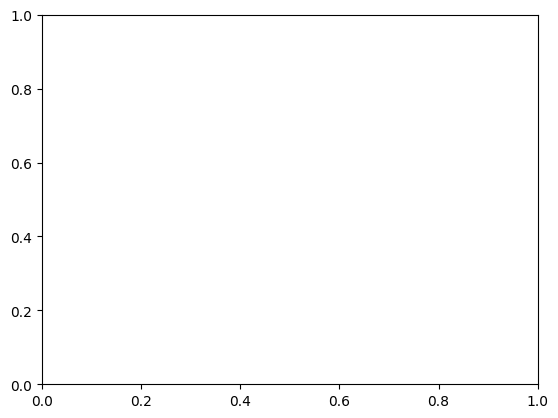

In [8]:
showX = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 149]
showY1 = []
showY2 = []

for epoch_index in range(num_epochs):
    for X, y in dataset_train:
        with tf.GradientTape() as tape:
            y_pred = model(X)
            tr_mse = tf.reduce_mean(tf.square(y_pred - y))
        grads = tape.gradient(tr_mse, model.variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
    if epoch_index % 10 == 0 or epoch_index == num_epochs - 1:
        tr_EC = tf.reduce_mean(tf.reduce_sum(tf.square(y_pred), axis=1))
        tr_rmse = tf.sqrt(tr_mse)
        tr_mae = tf.reduce_mean(tf.abs(y_pred - y))
        tr_r2 = 1 - tf.reduce_sum(tf.square(y_pred - y)) / tf.reduce_sum(tf.square(y - tf.reduce_mean(y)))
        print("epoch:{}".format(epoch_index))
        print("train mse:{} rmse:{} mae:{} r2:{} EC:{}".format(tr_mse, tr_rmse, tr_mae, tr_r2, tr_EC))
        # y_v_p = model(X_v[:,1:], X_v[:,:1])
        # va_mse = tf.reduce_mean(tf.square(y_v_p - y_v))
        # va_rmse = tf.sqrt(va_mse)
        # va_mae = tf.reduce_mean(tf.abs(y_v_p - y_v))
        # va_r2 = 1 - tf.reduce_sum(tf.square(y_v_p - y_v)) / tf.reduce_sum(tf.square(y_v - tf.reduce_mean(y_v)))
        # print("vali mse:{} rmse:{} mae:{} r2:{}".format(va_mse, va_rmse, va_mae, va_r2))
        GT_y = model(GT_X)
        # GT_loss = loss_func(GT_y[0:1], GT_y[1:2], GT_y[2:3], GT_y[3:4], GT_y[4:5], GT_y[5:6]) + loss_func(GT_y[6:7], GT_y[7:8], GT_y[8:9], GT_y[9:10], GT_y[10:11], GT_y[11:12])
        GT_mse = tf.reduce_mean(tf.square(GT_y - GT_S))
        GT_rmse = tf.sqrt(GT_mse)
        GT_mae = tf.reduce_mean(tf.abs(GT_y - GT_S))
        GT_r2 = 1 - tf.reduce_sum(tf.square(GT_y - GT_S)) / tf.reduce_sum(tf.square(GT_S - tf.reduce_mean(GT_S)))
        print("GT mse:{} rmse:{} mae:{} r2:{}".format(GT_mse, GT_rmse, GT_mae, GT_r2))
        showY1.append(tr_r2)
        # showY2.append(va_r2)
plt.plot(showX, showY1)
# plt.plot(showX, showY2)
plt.ylim(0, 1)
plt.show()

In [9]:
tf.saved_model.save(model, './models')

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


In [6]:
model = tf.saved_model.load('./models')

In [9]:
def dgn_obj(s_para, dis = False):
    E = tf.square(s_para)
    E11 = E[:,0] + E[:,1]
    E21 = E[:,2] + E[:,3]
    E31 = E[:,4] + E[:,5]
    E41 = E[:,6] + E[:,7]
    l1 = E11 - E21 - E31 + E41
    l2 = tf.abs(E21 / (E31 + E21) - 0.71)
    # l2 = tf.abs(E21 / (E31 + E21) - 0.5)
    l3 = tf.abs(tf.math.atan2(s_para[:,3], s_para[:,2]) - tf.math.atan2(s_para[:,5], s_para[:,4]) - np.pi / 4)
    # l3 = tf.abs(tf.math.atan2(s_para[:,5], s_para[:,4]) - tf.math.atan2(s_para[:,3], s_para[:,2]) - 0.14 * np.pi)
    l4 = tf.abs(tf.reduce_sum(E, axis=1) - 1)
    loss = l1 + l2 + l3 + l4
    if dis == True:
        print("l1", l1.numpy()[0])
        print("l2", l2.numpy()[0])
        print("l3", l3.numpy()[0])
        print("l4", l4.numpy()[0])
    return loss
def loss_func(s1, s2, s3, dis = False):
    # 21和31的方差
    var = tf.reduce_sum(tf.nn.moments(tf.stack([s1, s2, s3], axis=1), [1])[1][:, 2: 6], axis=-1)
    if dis == True:
        print("var", var.numpy()[0])
    return var + dgn_obj(s1, dis) + dgn_obj(s2, dis) + dgn_obj(s3, dis)

In [10]:
num_nodes = 10000
num_node_epochs = 1000

In [11]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

mmin = np.min(full_X[: , 1: ], axis=0)
mmax = np.max(full_X[: , 1: ], axis=0)

structure = tf.Variable(np.random.uniform(mmin, mmax, (num_nodes, 12)), dtype=tf.float32)

freq1 = tf.ones([num_nodes, 1]) * 2.4
freq2 = tf.ones([num_nodes, 1]) * 2.5
freq3 = tf.ones([num_nodes, 1]) * 2.6

In [12]:
bestLoss = 10
bestStructure = 0

In [13]:
def check(structure):
    # inva_place1 = tf.where(structure[:,:8] < 1)
    inva_place1 = tf.where(tf.logical_or(structure[:,:8] < 1, structure[:,:8] > 4))
    structure = tf.tensor_scatter_nd_update(structure, [inva_place1], [np.random.uniform(mmin[inva_place1[:,1]], mmax[inva_place1[:,1]], (inva_place1.shape[0]))])
    
    # inva_place2 = tf.where(structure[:,8:] < 4) + [0, 8]
    inva_place2 = tf.where(tf.logical_or(structure[:,8:] < 4, structure[:,8:] > 100)) + [0, 8]
    structure = tf.tensor_scatter_nd_update(structure, [inva_place2], [np.random.uniform(mmin[inva_place2[:,1]], mmax[inva_place2[:,1]], (inva_place2.shape[0]))])
    
    return tf.Variable(structure)
    
    # structure[j] = tf.Variable(tf.tensor_scatter_nd_update(structure[j], [nega_place], [np.random.uniform(0, 1, (nega_place.shape[0]))]))

In [15]:
for i in range(num_node_epochs):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(structure)
        y_pred1 = model(tf.concat([freq1, structure], axis = 1))
        y_pred2 = model(tf.concat([freq2, structure], axis = 1))
        y_pred3 = model(tf.concat([freq3, structure], axis = 1))
        loss = loss_func(y_pred1, y_pred2, y_pred3)
    minLoss = tf.reduce_min(loss).numpy()
    minIndex = tf.argmin(loss).numpy()
    minS = structure[minIndex].numpy()
    grads = tape.gradient(loss, structure)
    opt.apply_gradients(grads_and_vars=zip([grads], [structure]))
    structure = check(structure)
    if minLoss < bestLoss:
        bestLoss = minLoss
        bestStructure = minS
        # bestStructure = data_loader.mmX.inverse_transform([minS[0]])[0]
        print(minIndex)
        print(i, bestLoss)
        print(" ".join(map(str, bestStructure)))
        print()

6612
0 -1.2867715
2.744742 3.2696228 1.1154009 1.247381 2.780528 4.4325614 1.4884144 2.877964 57.47476 70.78123 89.91173 18.568535

9633
1 -1.4643738
3.2664754 3.9773488 2.029168 1.2656635 1.885906 3.008105 3.2015023 3.6244848 14.332378 70.55785 15.663997 47.777084

9633
2 -1.4769361
3.2590342 3.9699075 2.0217266 1.2582225 1.8933474 3.000664 3.194061 3.6170435 14.324938 70.550415 15.656555 47.76964

9633
3 -1.4878525
3.2526462 3.9635193 2.0153387 1.2518346 1.8997355 2.9942763 3.1876729 3.6106555 14.31855 70.54403 15.650167 47.763252

9633
4 -1.4978743
3.246835 3.9577081 2.0095274 1.2460237 1.9055467 2.9884653 3.1818616 3.6048443 14.312739 70.538216 15.644357 47.757442

9633
5 -1.5074513
3.2413802 3.9522533 2.0040727 1.240569 1.9110014 2.9830108 3.1764069 3.5993896 14.307285 70.53276 15.638902 47.751987

9633
6 -1.5168791
3.236159 3.9470322 1.9988517 1.2353481 1.9162226 2.9777899 3.1711857 3.5941684 14.302065 70.52754 15.63368 47.746765

9633
7 -1.5261279
3.2310953 3.9419684 1.993788 1.

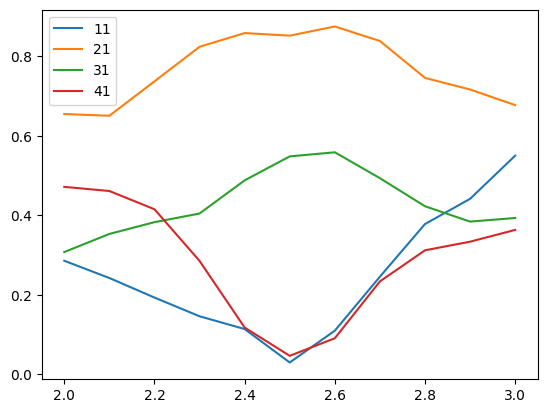

In [16]:
# 画图
fig_freq = tf.linspace(2.0, 3.0, 11)
fig_x = tf.concat([tf.reshape(fig_freq, (-1, 1)), tf.tile([bestStructure], [11, 1])], axis=-1)
fig_y = model(fig_x)
E = tf.square(fig_y)
M11 = tf.sqrt(E[:,0] + E[:,1])
M21 = tf.sqrt(E[:,2] + E[:,3])
M31 = tf.sqrt(E[:,4] + E[:,5])
M41 = tf.sqrt(E[:,6] + E[:,7])
plt.figure()
plt.plot(fig_freq, M11, label='11')
plt.plot(fig_freq, M21, label='21')
plt.plot(fig_freq, M31, label='31')
plt.plot(fig_freq, M41, label='41')
plt.legend()
plt.show()

In [20]:
# S4P
l = fig_y.numpy().tolist()
for i in range(len(l)):
    print(round(fig_freq.numpy()[i]*10,0) / 10, end="\t")
    print(l[i][0], l[i][1], "0\t" * 6, sep="\t")
    print(l[i][2], l[i][3], "0\t" * 6, sep="\t")
    print(l[i][4], l[i][5], "0\t" * 6, sep="\t")
    print(l[i][6], l[i][7], "0\t" * 6, sep="\t")

2.0	-0.23744863271713257	0.1585748791694641	0	0	0	0	0	0	
0.3169764578342438	0.5730642080307007	0	0	0	0	0	0	
0.26671358942985535	0.15294185280799866	0	0	0	0	0	0	
-0.3534296452999115	-0.3121873438358307	0	0	0	0	0	0	
2.1	-0.16129299998283386	0.18055832386016846	0	0	0	0	0	0	
0.41522762179374695	0.5007677674293518	0	0	0	0	0	0	
0.3419952690601349	0.08766975998878479	0	0	0	0	0	0	
-0.4143267571926117	-0.20238299667835236	0	0	0	0	0	0	
2.2	-0.05874094367027283	0.18376463651657104	0	0	0	0	0	0	
0.6076681017875671	0.4173007011413574	0	0	0	0	0	0	
0.38265979290008545	-0.0025033243000507355	0	0	0	0	0	0	
-0.3977512717247009	-0.11926047503948212	0	0	0	0	0	0	
2.3	0.034953080117702484	0.1415717899799347	0	0	0	0	0	0	
0.760367751121521	0.31797271966934204	0	0	0	0	0	0	
0.38742613792419434	-0.11620983481407166	0	0	0	0	0	0	
-0.27116745710372925	-0.08826754987239838	0	0	0	0	0	0	
2.4	0.07805349677801132	0.08258641511201859	0	0	0	0	0	0	
0.8398392200469971	0.17873041331768036	0	0	0	0	0	0	
0.4090041220188141	-0.265

In [21]:
MP_X = tf.concat([tf.constant([[2.4],[2.5],[2.6]]), tf.tile([bestStructure], [3, 1])], axis=-1)
GT_X = tf.concat([tf.constant([[2.4],[2.5],[2.6]]), tf.tile([GT_struct], [3, 1])], axis=-1)
MP_y = model(MP_X)
GT_y = model(GT_X)
print("MP")
MP_loss = loss_func(MP_y[0:1], MP_y[1:2], MP_y[2:3], dis=True)
print(MP_loss)
print("GT")
GT_loss = loss_func(GT_y[0:1], GT_y[1:2], GT_y[2:3], dis=True)
print(GT_loss)

MP
var 0.06762899
l1 -0.9485848
l2 0.045953155
l3 0.00084114075
l4 0.0019978285
l1 -1.0237658
l2 0.0027507544
l3 0.013370097
l4 0.029781222
l1 -1.0579048
l2 0.0006021857
l3 0.00034672022
l4 0.09825075
tf.Tensor([-2.7687325], shape=(1,), dtype=float32)
GT
var 0.06761725
l1 -1.014471
l2 0.019116282
l3 0.2232998
l4 0.0374434
l1 -1.0650313
l2 0.069173515
l3 0.24932879
l4 0.07350016
l1 -1.0188986
l2 0.08199364
l3 0.13976085
l4 0.075478196
tf.Tensor([-2.0616891], shape=(1,), dtype=float32)


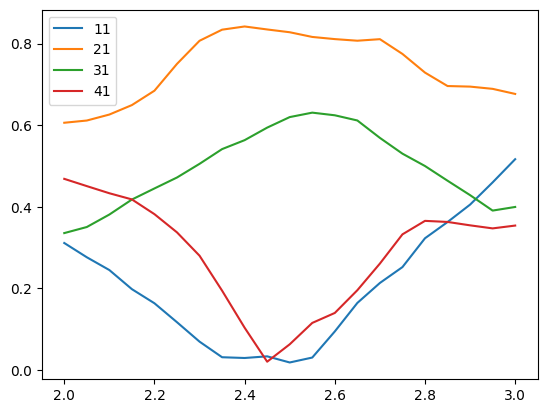

In [16]:
# 画图
fig_freq = tf.linspace(2.0, 3.0, 21)
fig_x = tf.concat([tf.reshape(fig_freq, (-1, 1)), tf.tile([GT_struct], [21, 1])], axis=-1)
fig_y = model(fig_x)
E = tf.square(fig_y)
M11 = tf.sqrt(E[:,0] + E[:,1])
M21 = tf.sqrt(E[:,2] + E[:,3])
M31 = tf.sqrt(E[:,4] + E[:,5])
M41 = tf.sqrt(E[:,6] + E[:,7])
plt.figure()
plt.plot(fig_freq, M11, label='11')
plt.plot(fig_freq, M21, label='21')
plt.plot(fig_freq, M31, label='31')
plt.plot(fig_freq, M41, label='41')
plt.legend()
plt.show()